In [8]:
from paths import *
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from sklearn.preprocessing import StandardScaler
import torch 
from matplotlib import pyplot as plt
import numpy as np
from src.plotting.save_plot import save_plot
# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

C:\Users\andre\AppData\Local\Temp\ipykernel_2544\2697538089.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [12]:
def plot_pca_laodings(sorted_eigenvectors, h=3, w=3):
    plt.clf()
    fig, axs = plt.subplots(h, w, figsize=(15, 5))

    for i in range(h):
        for j in range(w):
            ax = axs[i, j]
            ax.plot(sorted_eigenvectors[:, h*i+j])
            ax.set_xlabel('Wavenumber')
            ax.set_ylabel('Loading')
            ax.set_title('PC'+str(h*i+j+1))
    plt.tight_layout()
    return plt

# plot explained variance for first 10 pcs
def plot_pca_explained_variance(sorted_eigenvalues, h=3, w=3):
    plt.clf()
    plt.figure(figsize=(10, 6))
    plt.bar(range(1,10+1), sorted_eigenvalues[:10] / sorted_eigenvalues.sum(), alpha=0.5, align='center', 
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    return plt


def plot_pca_latent_space(projected_data, y, labs = ["alpha"]):
    plt.clf()
    if len(labs) == 1:
        plt.scatter(projected_data[:, 0], projected_data[:, 0+1], c=y[:, 0 if labs[0] == "c" else 3], cmap='viridis')
        plt.xlabel('PC'+str(0+1))
        plt.ylabel('PC'+str(0+2))
        # colorbar
        cbar = plt.colorbar()
        cbar.set_label(labs[0])
    else:
        # subplots for each label
        fig, axs = plt.subplots(1, len(labs), figsize=(15, 5))
        for i in range(len(labs)):
            ax = axs[i]
            ax.scatter(projected_data[:, 0], projected_data[:, 0+1], c=y[:, 0 if labs[i] == "c" else 3], cmap='viridis')
            ax.set_xlabel('PC'+str(1))
            ax.set_ylabel('PC'+str(1+1))
            # colorbar
            cbar = fig.colorbar(ax.collections[0], ax=ax)
            cbar.set_label(labs[i])
    
    return plt

def plot_pca_reconstructions(data, projected_data, sorted_eigenvectors, num_components=2 ,w=3, h=3):
    plt.clf()
    reconstructed_data = projected_data @ sorted_eigenvectors[:, :num_components].T
    # reconstructed_data = scaler.inverse_transform(reconstructed_data)

    fig, axs = plt.subplots(h, w, figsize=(15, 5))

    for i in range(h*w):
        ax = axs[i//w, i%w]
        ax.plot(data[i], label='Original')
        ax.plot(reconstructed_data[i], label='Reconstructed')
        ax.set_xlabel('Wavenumber')
        ax.set_ylabel('Intensity')
        ax.set_title('Sample '+str(i+1))
        ax.legend(loc='best', frameon=True)
        
    plt.tight_layout()

    return plt

Generator 1 reconstruction MSE: 0.24915537651867628
Generator 2 reconstruction MSE: 1.3700736152237334
Generator 3 reconstruction MSE: 1.8532375186966592


<Figure size 800x550 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

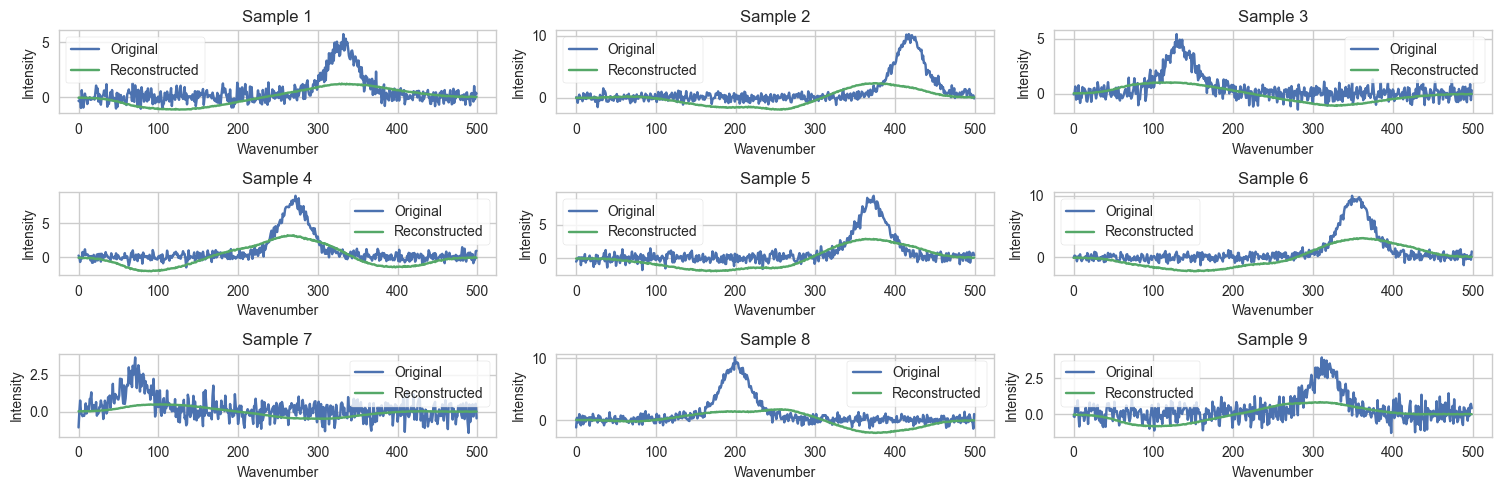

In [14]:

for generator_num in [1, 2, 3]:
    ps = pseudoVoigtSimulatorTorch(500)
    generator = ps.predefined_generator(generator_num)

    num_samples = 1000  # Specify the number of samples you want to generate
    data = np.empty((num_samples, 500))  # Create an empty array to store the generated data
    labels = np.empty((num_samples, 4))  # Create an empty array to store the generated data
    for i in range(num_samples):
        x, y = next(generator)  # Generate the next vector from the generator
        data[i] = x  # Store the vector in the data array
        labels[i] = y.flatten()
        
    # scaler = StandardScaler()
    # scaled_data = scaler.fit_transform(data)

    scaled_data = data
    cov_matrix = np.cov(scaled_data, rowvar=False)

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    num_components = 2  # Choose the number of components to retain
    # projected_data = scaled_data @ sorted_eigenvectors[:, :num_components]
    projected_data = scaled_data @ sorted_eigenvectors[:, :num_components]

    reconstructed_data = projected_data @ sorted_eigenvectors[:, :num_components].T
    mse = ((data - reconstructed_data)**2).mean(axis=1)
    print(f"Generator {generator_num} reconstruction MSE: {mse.mean()}")

    plot = plot_pca_explained_variance(sorted_eigenvalues)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "0_PCA", "PCA_explained_variance_" + str(generator_num)), ["pdf", "png"])

    plot = plot_pca_laodings(sorted_eigenvectors)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "0_PCA", "PCA_loadings_" + str(generator_num)), ["pdf", "png"])

    if generator_num == 1:
        labs = ["alpha"]
    elif generator_num == 2:
        labs = ["c"]
    elif generator_num == 3:
        labs = ["c", "alpha"]

    plot = plot_pca_latent_space(projected_data, labels, labs=labs)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "0_PCA", "PCA_latent_space_" + str(generator_num)), ["pdf", "png"])

    plot = plot_pca_reconstructions(data, projected_data, sorted_eigenvectors, num_components=num_components, w=3, h=3)    
    save_plot(plot, os.path.join(report_dir, "figures", "results", "0_PCA", "PCA_reconstructions_" + str(generator_num)), ["pdf", "png"])
